In [4]:
# Importing libraries and dependecies 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout,LSTM
#from keras import backend as K
from keras import optimizers

In [5]:
# setting up a random seed for reproducibility
random_seed = 611
np.random.seed(random_seed)

# matplotlib inline
plt.style.use('ggplot')

LABELS = ['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking']

In [6]:
#---------------------------------Dataset and Preprocessing---------------------------------------
def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))


def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma
    
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activity,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()
    
def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)

def segment_signal(data,window_size = 90,step = 45):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for i in range(0, len(data) - window_size, step):
#    for (start, end) in windows(data['timestamp'], window_size):
        x = data["x-axis"][i:i+window_size]
        y = data["y-axis"][i:i+window_size]
        z = data["z-axis"][i:i+window_size]
#        if(len(dataset['timestamp'][i:i+window_size] == window_size):
        segments = np.vstack([segments,np.dstack([x,y,z])])
        labels = np.append(labels,stats.mode(data["activity"][i:i+window_size])[0][0])
#        print(".", end="")
#        print(i,".", i+window_size)
        
    return segments, labels

def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [8]:
#------------------------------reading the data------------------------------------------
    
dataset = read_data('../WISDM_ar_v1.1_raw.txt')


dataset.dropna(axis=0, how='any', inplace= True)
# =============================================================================
# dataset = dataset[dataset.activity != 'Jogging']
# dataset = dataset[dataset.activity != 'Standing']
# dataset = dataset[dataset.activity != 'Walking']
# =============================================================================

#------------------------Normalize features for training data set (values between 0 and 1)-----------------------
# This must also be done to testing set later
pd.options.mode.chained_assignment = None  # default='warn'
dataset['x-axis'] = dataset['x-axis'] / dataset['x-axis'].max()
dataset['y-axis'] = dataset['y-axis'] / dataset['y-axis'].max()
dataset['z-axis'] = dataset['z-axis'] / dataset['z-axis'].max()

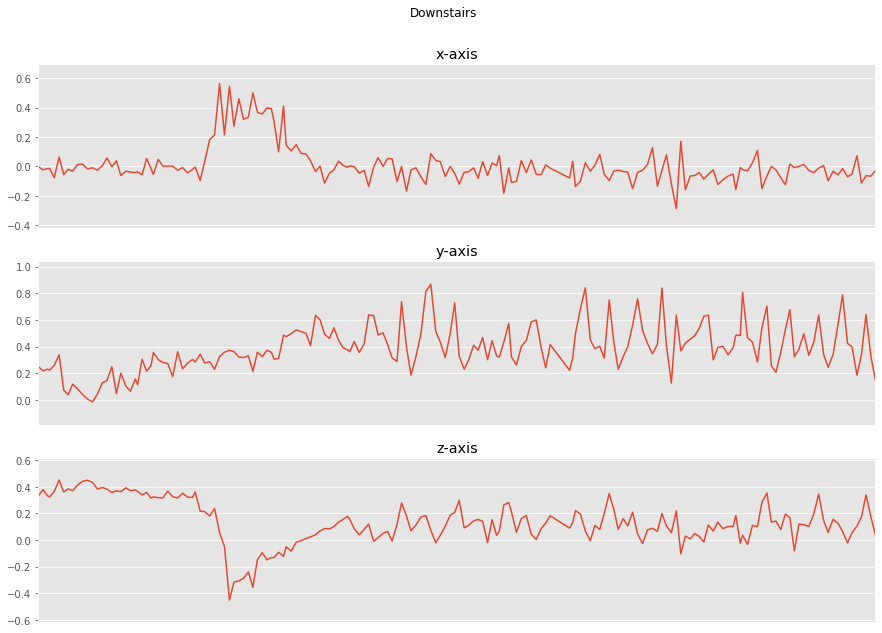

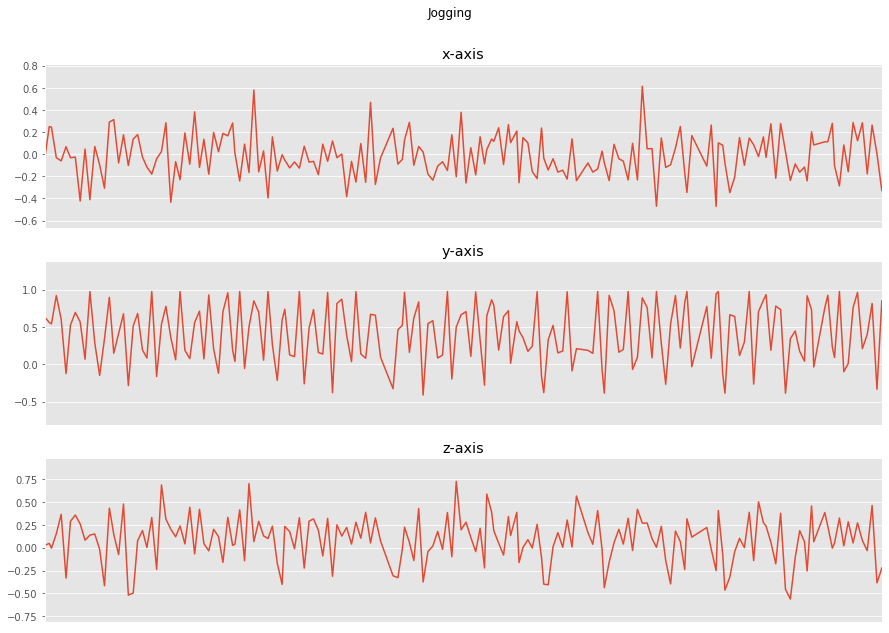

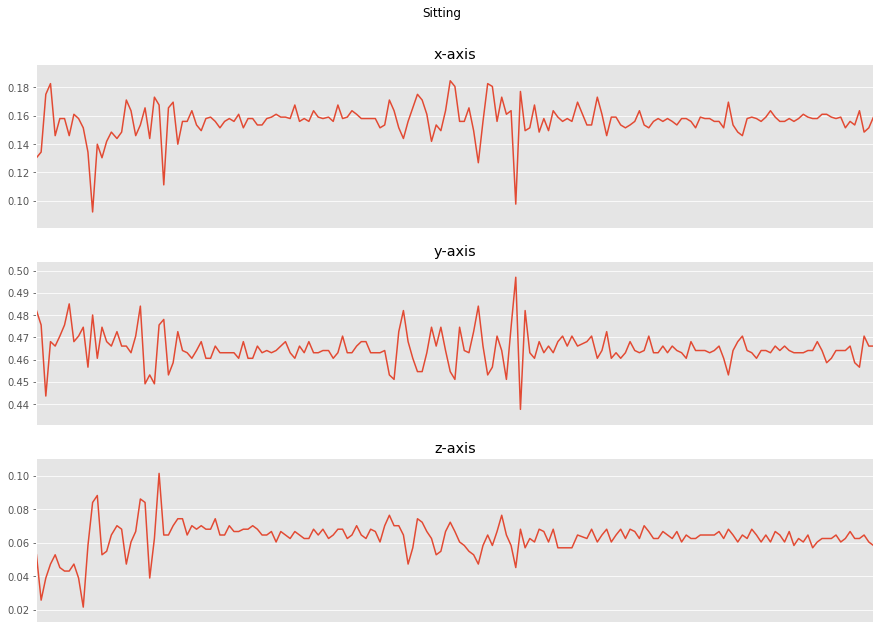

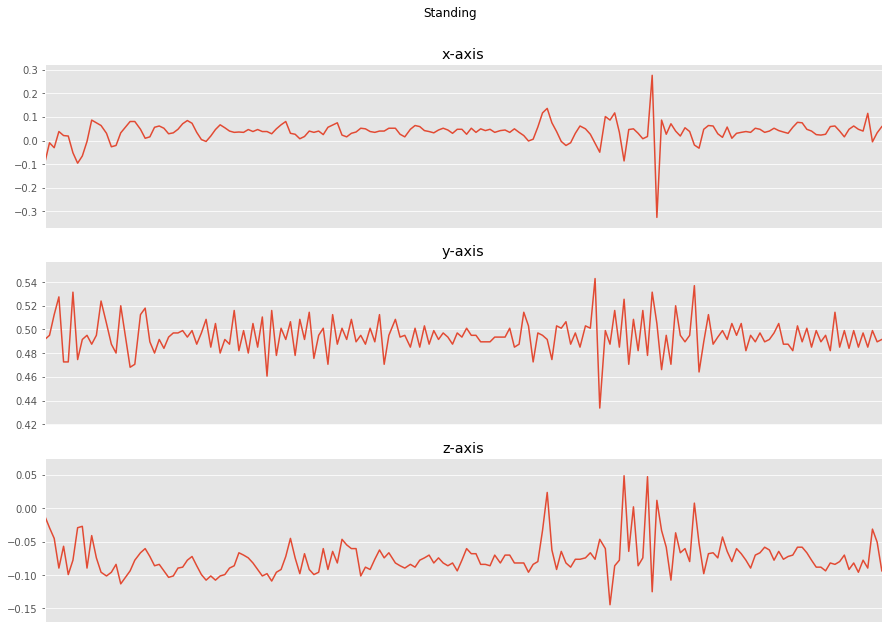

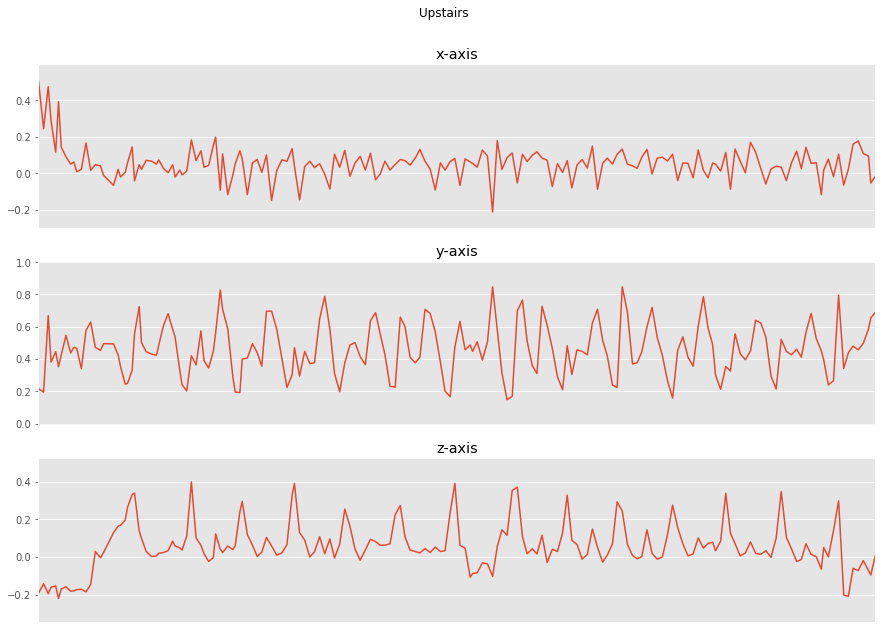

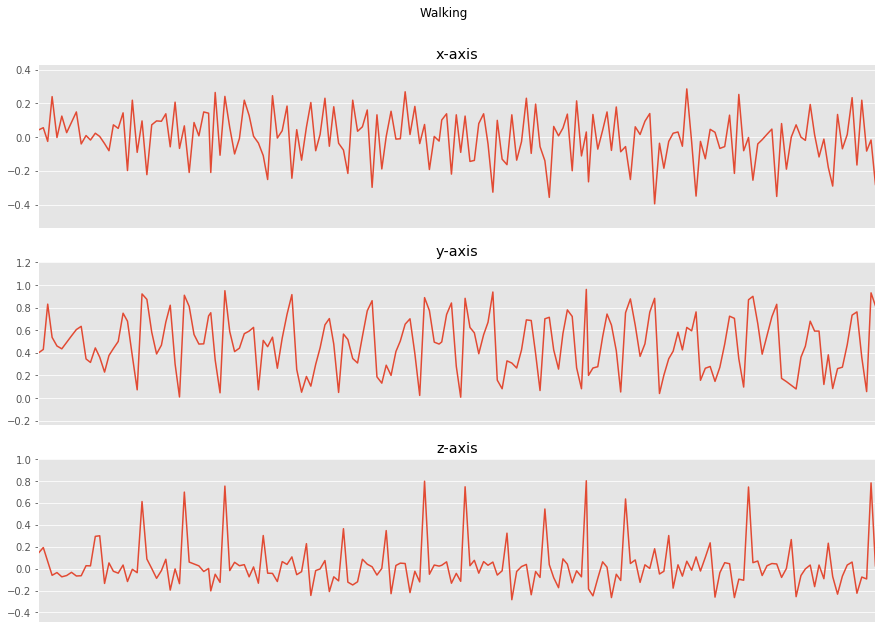

In [9]:
# Plotting a subset of the data to visualize
for activity in np.unique(dataset["activity"]):
    subset = dataset[dataset["activity"] == activity][:180]
    plot_activity(activity,subset)

In [11]:
# Segmenting the signal in overlapping windows of 90 samples with 50% overlap
#segments, labels = segment_signal(dataset,90,45) 

# Writing toJson for later use.
# =============================================================================
# np.save("segments", segments)
# np.save("labels", labels)
#
segments = np.load("../dumps/segments.npy")
labels = np.load("../dumps/labels.npy")

In [12]:
# Categorically defining the classes of the activities
labels = np.asarray(pd.get_dummies(labels),dtype = np.int8)

# Parameters for the input and network layers
# we are treating each segmeent or 2D Matrix (90 x 3)
numOfRows = segments.shape[1]
numOfColumns = segments.shape[2]
numChannels = 1
numFilters = 128 # number of filters in Conv2D layer

# Size of the Conv2D layer
kernalSize1 = 2
poolingWindowSz = 2
numNueronsFCL1 = 128
numNueronsFCL2 = 128
trainSplitRatio = 0.8
Epochs = 50
batchSize = 400
numClasses = labels.shape[1]
dropOutRatio = 0.2

In [13]:
reshapedSegments = segments.reshape(segments.shape[0], numOfRows, numOfColumns,1)
# splitting in training and testing data
trainSplit = np.random.rand(len(segments)) < trainSplitRatio
trainX = reshapedSegments[trainSplit]
testX = reshapedSegments[~trainSplit]
trainX = np.nan_to_num(trainX)
testX = np.nan_to_num(testX)
trainY = labels[trainSplit]
testY = labels[~trainSplit]


In [14]:
def cnnModel():
    
    model = Sequential()
    # First convolutionial layer with 32 filters and 5 by 5 kernal size.
    model.add(Conv2D(numFilters, (kernalSize1,kernalSize1),input_shape=(numOfRows, numOfColumns, 1),activation='relu'))
    # Maxpooling layer
    model.add(MaxPooling2D(pool_size=(poolingWindowSz,poolingWindowSz),padding='valid'))
    # Dropout layer for the regularization and avoiding over fitting
    model.add(Dropout(dropOutRatio))
    # Fattening the output in order to apply the fully connected layer
    model.add(Flatten())
    # First fully connected layer with 256 outputs
    model.add(Dense(numNueronsFCL1, activation='relu'))
    # Second fully connected layer 128 outputs
    model.add(Dense(numNueronsFCL2, activation='relu'))
    # Softmax layer for the classification
    model.add(Dense(numClasses, activation='softmax'))
    
    return model

model = cnnModel()

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 89, 2, 128)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 44, 1, 128)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 44, 1, 128)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5632)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               721024    
_________________________________________________________________
dense_2 (Dense)      

In [15]:
#-----------------------------------Fit the DNN Model in Keras-------------------------------------------
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{val_acc:.2f}-{acc:.2f}-{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=2)
]

adam = optimizers.Adam(lr = 0.01, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])


In [16]:
#-----------------------------------Fit the modal to training set-------------------------------------------
history = model.fit(trainX,trainY, validation_split=1-trainSplitRatio,epochs=10,batch_size=batchSize,verbose=1,
                      callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Train on 15609 samples, validate on 3903 samples
Epoch 1/10
15609/15609 [==============================] - 9s 602us/step - loss: 1.3011 - acc: 0.5756 - val_loss: 1.5581 - val_acc: 0.5211
Epoch 2/10
15609/15609 [==============================] - 9s 554us/step - loss: 0.6846 - acc: 0.7467 - val_loss: 0.7124 - val_acc: 0.7610
Epoch 3/10
15609/15609 [==============================] - 8s 527us/step - loss: 0.5427 - acc: 0.7940 - val_loss: 0.8824 - val_acc: 0.6872
Epoch 4/10
15609/15609 [==============================] - 9s 550us/step - loss: 0.4746 - acc: 0.8166 - val_loss: 0.8345 - val_acc: 0.6977
Epoch 5/10
15609/15609 [==============================] - 9s 552us/step - loss: 0.4264 - acc: 0.8400 - val_loss: 0.6808 - val_acc: 0.7571
Epoch 6/10
15609/15609 [==============================] - 8s 526us/step - loss: 0.3756 - acc: 0.8576 - val_loss: 0.6897 - val_acc: 0.7545
Epoch 7/10
15609/15609 [==============================] - 8s 520us/step - l

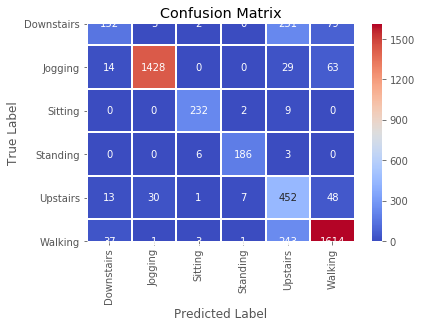

              precision    recall  f1-score   support

         0.0       0.70      0.32      0.44       469
         1.0       0.98      0.93      0.95      1534
         2.0       0.95      0.95      0.95       243
         3.0       0.95      0.95      0.95       195
         4.0       0.47      0.82      0.60       551
         5.0       0.89      0.85      0.87      1899

   micro avg       0.83      0.83      0.83      4891
   macro avg       0.82      0.81      0.79      4891
weighted avg       0.86      0.83      0.83      4891



In [17]:
# Print confusion matrix for training data
y_pred_test = model.predict(testX)

# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_test, axis=1)

# getting the class predicted and class in ground truth for creation of confusion matrix
predictedClass = np.zeros((y_pred_test.shape[0]))
groundTruthClass = np.zeros((testY.shape[0]))
for instance in range (testY.shape[0]):
    predictedClass[instance] = np.argmax(y_pred_test[instance,:])
    groundTruthClass[instance] = np.argmax(testY[instance,:])

# Visualizing the result
show_confusion_matrix(groundTruthClass, predictedClass)
print(classification_report(groundTruthClass, predictedClass))

#model.save('model.h5')